In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import stats as st
import random

In [2]:
path = "./DataLab4.xlsx"
df = pd.read_excel(path)
df

,Rating,Prob_Loan_BBB,Loss_BBB,Prob_Loan_A,Loss_A
0,AAA,0.0002,-2.28,0.0009,-0.45
1,AA,0.0033,-2.10,0.0227,-0.23
2,A,0.0595,-1.57,0.9105,-0.12
3,BBB,0.8693,-0.46,0.0552,1.08
4,BB,0.0530,5.07,0.0074,3.16
5,B,0.0117,8.99,0.0026,5.56
6,CCC,0.0012,23.45,0.0001,18.78
7,D,0.0018,55.96,0.0006,55.96


**How many upgrades and downgrades to each rating in one year do we expect, given the probability migration table and the fact that we are using M = 100, 000 simulations (draws)? That is how many times out of 100,000 will the loan with an initial BBB rating get AAA, AA, ...D?**

Answer: Since the probabilities of transition to the differents ratings are given in the table, the amount of simulations that end up in each category should be prob\*M, that is for example P(BBB)\*M = 0.8693\*100000 = 86930. Below we do the simulations to conclude this:

In [4]:
M = int(1e5)
samples = pd.Series(random.choices(population=df.Rating, weights=df.Prob_Loan_BBB, k=M))
samples.value_counts().sort_values(ascending = False)

BBB    86892
A       5988
BB      5274
B       1154
AA       351
D        190
CCC      131
AAA       20
dtype: int64

We see that this is approximately what we could expect.

In [5]:
# 2
alphas = [0.99, 0.999, 0.9999]
mu = 0
sig_p = 3.35
for alpha in alphas:
    VaR = mu + st.norm.ppf(alpha)*sig_p
    print(f"The {alpha*100}%-VaR is: {VaR:.4f}")

The 99.0%-VaR is: 7.7933
The 99.9%-VaR is: 10.3523
The 99.99%-VaR is: 12.4587


In [6]:
# 3a)
x1 = np.random.normal(0,1,M)
x2 = np.random.normal(0,1,M)

In [7]:
df

,Rating,Prob_Loan_BBB,Loss_BBB,Prob_Loan_A,Loss_A
0,AAA,0.0002,-2.28,0.0009,-0.45
1,AA,0.0033,-2.10,0.0227,-0.23
2,A,0.0595,-1.57,0.9105,-0.12
3,BBB,0.8693,-0.46,0.0552,1.08
4,BB,0.0530,5.07,0.0074,3.16
5,B,0.0117,8.99,0.0026,5.56
6,CCC,0.0012,23.45,0.0001,18.78
7,D,0.0018,55.96,0.0006,55.96


In [8]:
# 3b)
BBB_quant = -st.norm.ppf(df.Prob_Loan_BBB.cumsum())
BBB_quant = np.delete(BBB_quant,-1)
BBB_quant = np.insert(BBB_quant,3,np.nan)

A_quant = -st.norm.ppf(df.Prob_Loan_A.cumsum())
A_quant = np.delete(A_quant,-1)
A_quant = np.insert(A_quant,2,np.nan)

q_df = pd.DataFrame({'rating': df.Rating,
                     'BBB_quantiles': BBB_quant,
                     'A_quantiles': A_quant,
                    },
                   )
q_df

,rating,BBB_quantiles,A_quantiles
0,AAA,3.540084,3.121389
1,AA,2.696844,1.984501
2,A,1.530068,NaN
3,BBB,NaN,-1.507042
4,BB,-1.493142,-2.300852
5,B,-2.178081,-2.716381
6,CCC,-2.747781,-3.194651
7,D,-2.911238,-3.238880


In [9]:
# 4
R = 0.35
q1 = x1
q2 = R*x1+np.sqrt(1-R**2)*x2
print(f"The empirical correlation is {st.pearsonr(q1, q2)[0]:.4f}")

The empirical correlation is 0.3478


In [10]:
# 5
quantiles = q_df.BBB_quantiles[::-1].dropna().to_numpy()
quantiles = np.array([float('-inf'), *quantiles, float('inf')])                      

counts, bins = np.histogram(q1,quantiles)
rating_counts = {rating: count for rating, count in zip(reversed(q_df.rating),counts)}
rating_counts

{'D': 177,
 'CCC': 117,
 'B': 1176,
 'BB': 5216,
 'BBB': 86966,
 'A': 5986,
 'AA': 335,
 'AAA': 27}

In [11]:
# comparing to first task
samples.value_counts()

BBB    86892
A       5988
BB      5274
B       1154
AA       351
D        190
CCC      131
AAA       20
dtype: int64

**Very similar**

In [43]:
# 6
q_df['loss_bbb'] = df.Loss_BBB
q_df['loss_a'] = df.Loss_A
q_df

,rating,BBB_quantiles,A_quantiles,loss_bbb,loss_a
0,AAA,3.540084,3.121389,-2.28,-0.45
1,AA,2.696844,1.984501,-2.10,-0.23
2,A,1.530068,NaN,-1.57,-0.12
3,BBB,NaN,-1.507042,-0.46,1.08
4,BB,-1.493142,-2.300852,5.07,3.16
5,B,-2.178081,-2.716381,8.99,5.56
6,CCC,-2.747781,-3.194651,23.45,18.78
7,D,-2.911238,-3.238880,55.96,55.96


In [53]:
# 6 preparation
bbb_quant = q_df.BBB_quantiles[::-1].dropna().to_numpy()
bbb_quant = np.array([float('-inf'), *bbb_quant, float('inf')])                      

a_quant = q_df.A_quantiles[::-1].dropna().to_numpy()
a_quant = np.array([float('-inf'), *a_quant, float('inf')])                      

# sanity check:
movement = 2
counts, bins = np.histogram(movement,a_quant) #should be a loss of -0.23
print(counts)
print(q_df.loss_a[::-1])
np.dot(counts,q_df.loss_a[::-1])

[0 0 0 0 0 0 1 0]
7    55.96
6    18.78
5     5.56
4     3.16
3     1.08
2    -0.12
1    -0.23
0    -0.45
Name: loss_a, dtype: float64


-0.23

In [50]:
# 6 
losses = []
for bbb_movement, a_movement in zip(q1,q2):
    
    a_counts, bins = np.histogram(a_movement,a_quant)
    a_loss = np.dot(a_counts,q_df.loss_a[::-1])
    
    bbb_counts, bins = np.histogram(bbb_movement,bbb_quant)
    bbb_loss = np.dot(bbb_counts,q_df.loss_bbb[::-1])
    
    losses.append(a_loss+bbb_loss)

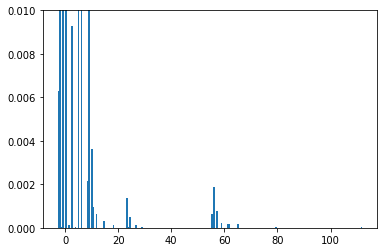

In [90]:
plt.hist(losses,bins = 200, density = True);
plt.ylim([0,0.01]);

In [91]:
# 7 with R = 0.35
VaRs = np.quantile(losses, [0.99,0.999,0.9999])
print(VaRs)

[ 8.87 55.84 64.95]


In [121]:
x1 = np.random.normal(0,1,M)
x2 = np.random.normal(0,1,M)

R = 0.95
q1 = x1
q2 = R*x1+np.sqrt(1-R**2)*x2
print(f"The empirical correlation is {st.pearsonr(q1, q2)[0]:.4f}")

The empirical correlation is 0.9501


In [122]:
losses = []
for bbb_movement, a_movement in zip(q1,q2):
    
    a_counts, bins = np.histogram(a_movement,a_quant)
    a_loss = np.dot(a_counts,q_df.loss_a[::-1])
    
    bbb_counts, bins = np.histogram(bbb_movement,bbb_quant)
    bbb_loss = np.dot(bbb_counts,q_df.loss_bbb[::-1])
    
    losses.append(a_loss+bbb_loss)
VaRs = np.quantile(losses, [0.99,0.999,0.9999])

In [112]:
print(f"VaRs for R = {R}: {VaRs}")

VaRs for R = -0.5: [ 8.87 55.84 55.84]


In [115]:
print(f"VaRs for R = {R}: {VaRs}")

VaRs for R = 0: [ 8.87 55.84 57.04]


In [118]:
print(f"VaRs for R = {R}: {VaRs}")

VaRs for R = 0.35: [ 8.87 55.84 61.03]


In [123]:
print(f"VaRs for R = {R}: {VaRs}")

VaRs for R = 0.95: [ 10.07  61.52 111.92]


**Question 1:**
The normal distribution is often too "forgiving" for tail events in real life applications. Since the degrees of freedom in this case is limited (all movements are mapped into eight magnitudes of losses, thus discretised), a t-distribution approximation would perhaps be more suitable, or something else with fatter tails. However, closer to the mean, where many events fall, the normal distribution is more correct and is therefore better for not-as-extreme cases as alpha = 0.9999.


**Question 2:** The asset correlation has a very high impact. With high correlation, the two loans are more and more similar and therefore less and less well hedged. As we can see above and as is remembered from first course in finance, two negatively correlated assets is a better hedge. For the highest correlation that we simulate, 0.95, we see that the highest VaR implies both loans defaulting, something that would be disastrous for the lender. If we think that we have spread our eggs into different baskets, but the destiny them show to be almost identical (dropping one makes us drop the other as well), one could argue that we have de facto put all eggs in one basket. 